In [2]:
%reset -f

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Path to your LAS file
file_path = './422393367200_WRA-1009_CXD_SEMB.las'

# Lists to hold the depth and log data (multiple logs)
depths = []
log_data = []

# Reading the LAS file manually
data_section = False  # To identify the start of the data section
with open(file_path, 'r') as las_file:
    for line in las_file:
        line = line.strip()  # Remove any leading/trailing whitespace

        # Look for the start of the data section (~A is the standard in LAS files)
        if line.startswith("~A"):
            data_section = True
            continue  # Skip the "~A" line itself

        # If we're in the data section, process the data
        if data_section:
            # Split the data line into components (assuming space-separated values)
            parts = line.split()
            if len(parts) >= 2:  # Ensure there are enough columns
                try:
                    # Convert the first column to depth and the rest to log data
                    depth = float(parts[0])
                    logs = [float(value) for value in parts[1:]]  # Store remaining columns as logs
                    # Only add valid data (exclude -9999 values)
                    if depth != -9999 and all(val != -9999 for val in logs):
                        depths.append(depth)
                        log_data.append(logs)
                except ValueError:
                    # Handle any lines that don't contain valid data
                    continue


In [4]:
# Convert to numpy arrays
depths = np.array(depths, dtype="float32")
# Convert depth from feet to meters (1 foot = 0.3048 meters)
depths = depths * 0.3048
log_data = np.array(log_data, dtype="float32")

# Define the formation tops in meters
formations = [
    {"name": "Glasscock", "top": 5465.68 * 0.3048},
    {"name": "Glasscock Base", "top": 5521.79 * 0.3048}
]


In [5]:
# Define rock matrix parameters for Gassmann's equations
K_matrix = 38e9  # Bulk modulus of rock matrix (Pa)
rho_matrix = 2650  # Matrix density (kg/m³)



# Define fluid properties
rho_oil = 690  # Density of oil (kg/m³)
rho_CO2 = 478.3  # Density of CO2 (kg/m³)

K_oil = 0.3758e9  # Bulk modulus of oil (Pa)
K_CO2 = 0.02853e9  # Bulk modulus of CO2 (Pa)





# Compute effective fluid properties for 50% CO2 injection
rho_fluid_mixture = 0.5 * rho_CO2 + 0.5 * rho_oil
K_fluid_mixture = 1 / (0.5 / K_CO2 + 0.5 / K_oil)

In [6]:
# Dry rock properties (calculated)
log_DTC = log_data[:, 5]  # Compressional slowness (μs/ft)
log_DTSX = log_data[:, 7]  # Shear slowness (μs/ft)
log_DEN = log_data[:, 3]  # Density log (g/cc)

# Convert slowness to velocity (m/s)
Vp = 304800 / log_DTC  # Convert DTC to P-wave velocity (m/s)
Vs = 304800 / log_DTSX  # Convert DTSX to S-wave velocity (m/s)

# Convert density from g/cc to kg/m³
rho = log_DEN * 1000  # Convert density to kg/m³

#Compute Shear Modulus (G_dry)
G_dry = rho * Vs**2  # Shear modulus (Pa)

#Compute Bulk Modulus (K_dry) for dry rock
K_dry = rho * (Vp**2 - (4/3) * Vs**2)  # Bulk modulus (Pa)

# K_dry = 10e9
# G_dry = 12e9

In [8]:
import numpy as np
import pandas as pd

# Define matrix and fluid densities
rho_matrix = 2.65* 1000  # For sandstone, for example
rho_fluid = 0.69* 1000      # For water, assuming the formation contains water

# Assuming log_DEN is your bulk density log
bulk_density = log_DEN* 1000  # Replace with the actual column from your data

# Calculate porosity from density
porosity_density = (rho_matrix - bulk_density) / (rho_matrix - rho_fluid)

In [10]:
# Matrix and fluid densities (adjust based on your formation)
rho_matrix_sh = 2.55  # Matrix density of shale (g/cm³)
rho_fluid = 0.676 # Fluid density of oil (g/cm³)

# Bulk density from the density log in shale zone
rho_bulk_shale = 2.24  # Replace with your actual density log data for shale region

# Compute shale porosity
phi_shale = (rho_matrix_sh - rho_bulk_shale) / (rho_matrix_sh - rho_fluid)

# Print or plot the results
print(f"Shale Porosity: {phi_shale}")

Shale Porosity: 0.16542155816435414


In [11]:
print(5465.68 * 0.3048),
print(5521.79 * 0.3048)

1665.939264
1683.041592


In [12]:
log_GRGC = log_data[:, 11]  # Customize this based on your parameter names

# Define your depth range (in meters) for which you want to find the min and max values
depth_min_range = 1665.939264   # Adjust this value based on your range
depth_max_range = 1683.041592  # Adjust this value based on your range

# Filter the data to include only values within the specified depth range
depth_filter = (depths >= depth_min_range) & (depths <= depth_max_range)
log_GRGC_filtered = log_GRGC[depth_filter]

# Compute the min and max of the filtered gamma-ray values
GR_min_range = np.min(log_GRGC_filtered)
GR_max_range = np.max(log_GRGC_filtered)

# Print the results
print(f"Gamma Ray Min (in range {depth_min_range}m - {depth_max_range}m): {GR_min_range}")
print(f"Gamma Ray Max (in range {depth_min_range}m - {depth_max_range}m): {GR_max_range}")


Gamma Ray Min (in range 1665.939264m - 1683.041592m): 55.91680145263672
Gamma Ray Max (in range 1665.939264m - 1683.041592m): 126.69599914550781


In [13]:
# Example data (adjust according to your log data)
log_GRGC = log_data[:, 11]  # Gamma Ray log (log_GRGC)
log_porosity_total = porosity_density  # Replace X with the column index of porosity_density
GR_min = 55.91680145263672  # Gamma Ray value for clean sandstone
GR_max = 126.69599914550781 # Gamma Ray value for pure shale

# 1. Calculate Gamma Ray Index (GRI)
I_GR = (log_GRGC - GR_min) / (GR_max - GR_min)

# 2. Calculate Volume of Shale (Vsh) for compacted formations (use the more complex formula)
Vsh = 0.083 * (2**(3.7 * I_GR) - 1)
# Ensure Vsh does not exceed 1 or drop below 0 (to account for outliers in the gamma-ray log)
Vsh = np.clip(Vsh, 0, 1)

# 3. Calculate Effective Porosity
# Effective porosity = Total porosity * (1 - Vsh)
#porosity_eff = log_porosity_total(1 - Vsh)
porosity_eff = log_porosity_total - Vsh * phi_shale

In [14]:
# Select porosity log column (assumed porosity is in percent)
porosity_log = porosity_eff / 100  # Convert porosity from percent to fraction

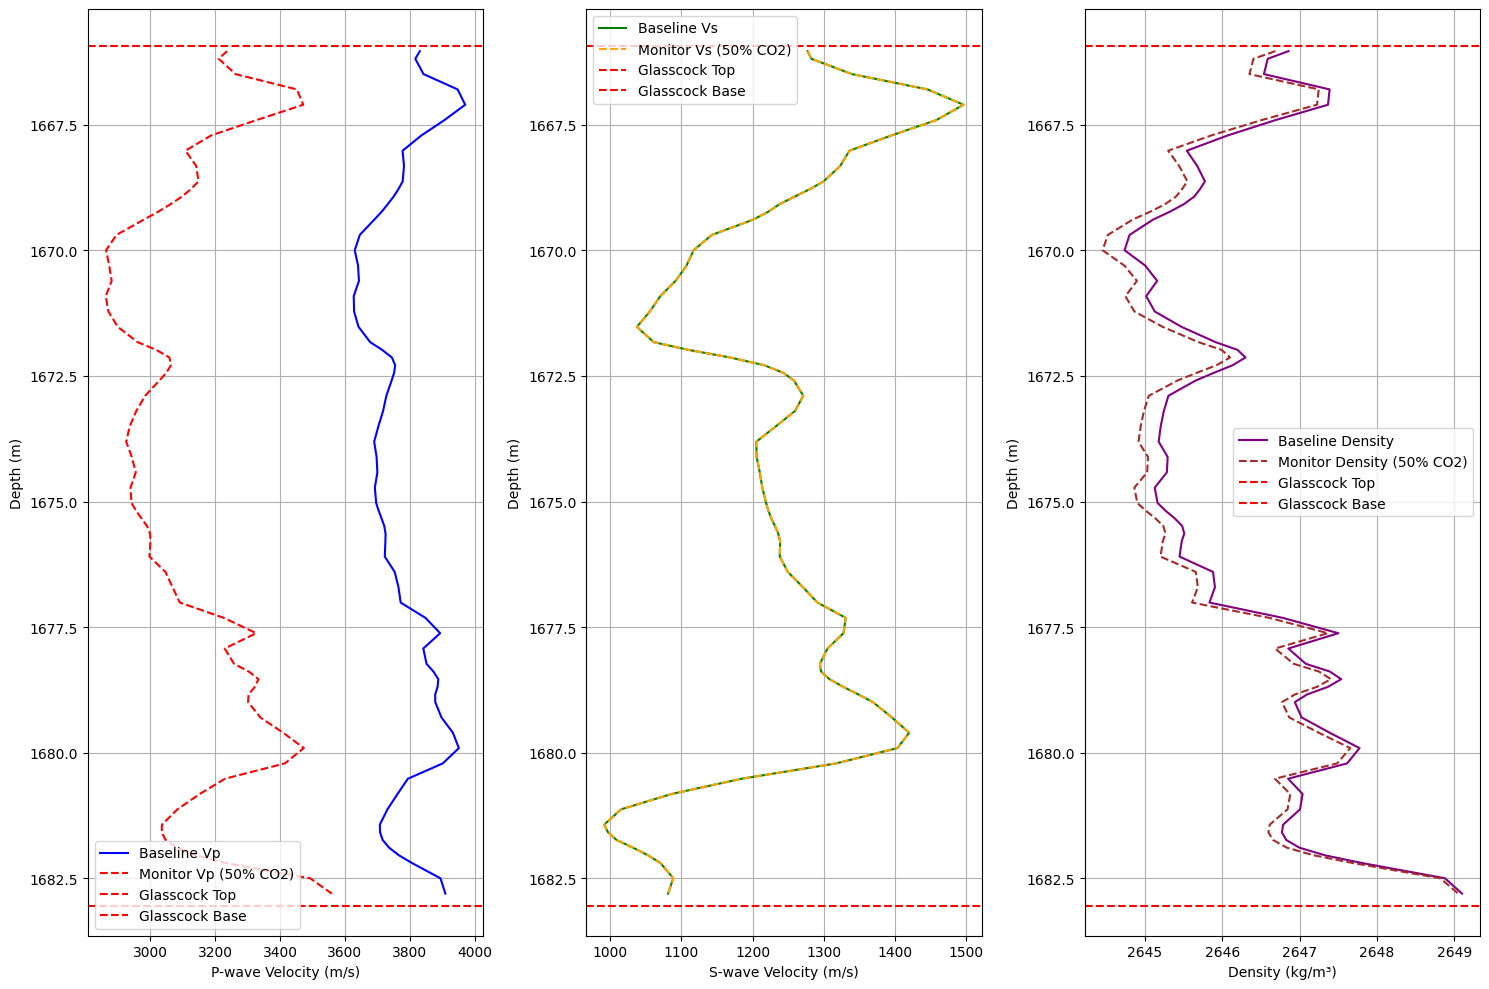

In [15]:
# Reservoir top and bottom in meters
formation_top = formations[0]['top']
formation_bottom = formations[1]['top']

# Filter data within the injection zone
injection_zone_mask = (depths >= formation_top) & (depths <= formation_bottom)
depth_injection = depths[injection_zone_mask]
porosity_injection = porosity_log[injection_zone_mask]
density_injection = rho[injection_zone_mask]

# Compute baseline bulk density (pre-CO2 injection)
rho_baseline = (1 - porosity_injection) * rho_matrix + porosity_injection * rho_oil

# Compute bulk density after 50% CO2 injection
rho_monitor = (1 - porosity_injection) * rho_matrix + porosity_injection * rho_fluid_mixture

# Apply Gassmann's fluid substitution equation
def gassmann(K_dry, K_matrix, K_fluid, porosity):
    """Apply Gassmann equation to calculate saturated bulk modulus."""
    numerator = (1 - K_dry / K_matrix)**2
    denominator = porosity / K_fluid + (1 - porosity) / K_matrix - K_dry / (K_matrix**2)
    K_sat = K_dry + numerator / denominator
    return K_sat

# Compute bulk modulus for baseline and monitor (post-CO2)
K_baseline = gassmann(K_dry[injection_zone_mask], K_matrix, K_oil, porosity_injection)
K_monitor = gassmann(K_dry[injection_zone_mask], K_matrix, K_fluid_mixture, porosity_injection)

# Compute Vp and Vs for baseline and monitoring survey
Vp_baseline = np.sqrt((K_baseline + (4 / 3) * G_dry[injection_zone_mask]) / rho_baseline)
Vs_baseline = np.sqrt(G_dry[injection_zone_mask] / rho_baseline)

Vp_monitor = np.sqrt((K_monitor + (4 / 3) * G_dry[injection_zone_mask]) / rho_monitor)
Vs_monitor = np.sqrt(G_dry[injection_zone_mask] / rho_monitor)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Plot Vp comparison
axes[0].plot(Vp_baseline, depth_injection, label='Baseline Vp', color='blue')
axes[0].plot(Vp_monitor, depth_injection, label='Monitor Vp (50% CO2)', color='red', linestyle='--')
axes[0].axhline(y=formation_top, color='red', linestyle='--', label='Glasscock Top')
axes[0].axhline(y=formation_bottom, color='red', linestyle='--', label='Glasscock Base')
axes[0].set_xlabel('P-wave Velocity (m/s)')
axes[0].set_ylabel('Depth (m)')
axes[0].invert_yaxis()
axes[0].legend()
axes[0].grid()

# Plot Vs comparison
axes[1].plot(Vs_baseline, depth_injection, label='Baseline Vs', color='green')
axes[1].plot(Vs_monitor, depth_injection, label='Monitor Vs (50% CO2)', color='orange', linestyle='--')
axes[1].axhline(y=formation_top, color='red', linestyle='--', label='Glasscock Top')
axes[1].axhline(y=formation_bottom, color='red', linestyle='--', label='Glasscock Base')
axes[1].set_xlabel('S-wave Velocity (m/s)')
axes[1].set_ylabel('Depth (m)')
axes[1].invert_yaxis()
axes[1].legend()
axes[1].grid()

# Plot Density comparison
axes[2].plot(rho_baseline, depth_injection, label='Baseline Density', color='purple')
axes[2].plot(rho_monitor, depth_injection, label='Monitor Density (50% CO2)', color='brown', linestyle='--')
axes[2].axhline(y=formation_top, color='red', linestyle='--', label='Glasscock Top')
axes[2].axhline(y=formation_bottom, color='red', linestyle='--', label='Glasscock Base')
axes[2].set_xlabel('Density (kg/m³)')
axes[2].set_ylabel('Depth (m)')
axes[2].invert_yaxis()
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()


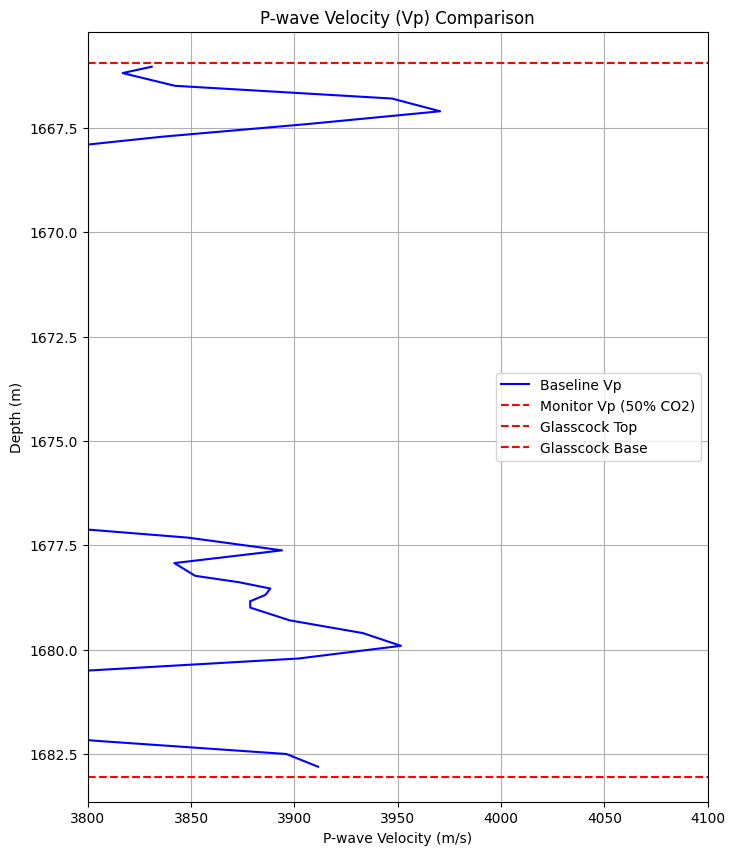

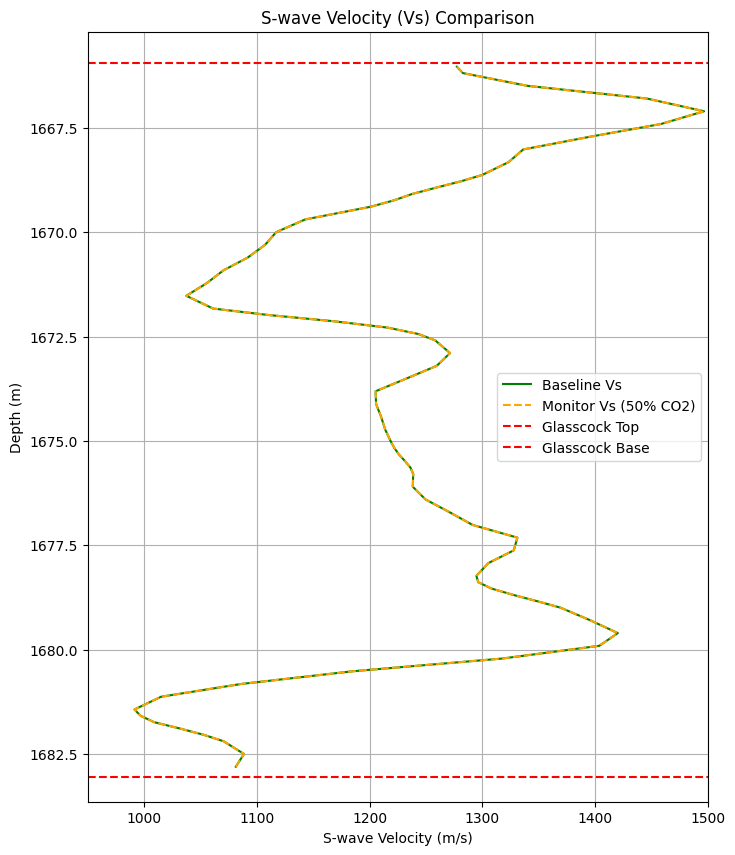

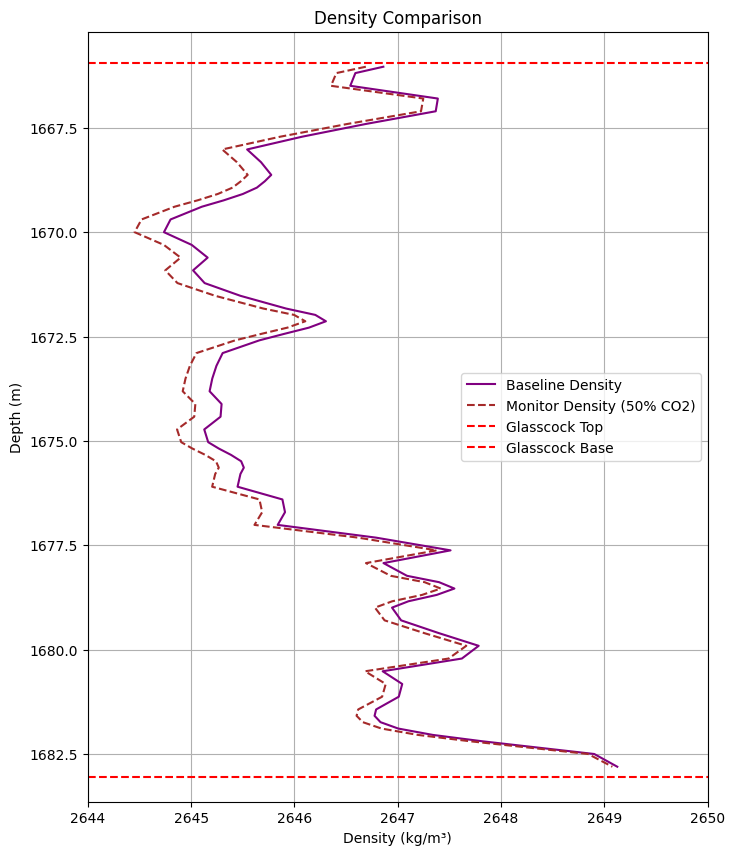

In [26]:
# Plot Vp comparison
plt.figure(figsize=(8, 10))
plt.plot(Vp_baseline, depth_injection, label='Baseline Vp', color='blue')
plt.plot(Vp_monitor, depth_injection, label='Monitor Vp (50% CO2)', color='red', linestyle='--')
plt.axhline(y=formation_top, color='red', linestyle='--', label='Glasscock Top')
plt.axhline(y=formation_bottom, color='red', linestyle='--', label='Glasscock Base')
plt.xlabel('P-wave Velocity (m/s)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.xlim(3800, 4100)

# Set y-axis range for depth
plt.title('P-wave Velocity (Vp) Comparison')
plt.show()

# Plot Vs comparison
plt.figure(figsize=(8, 10))
plt.plot(Vs_baseline, depth_injection, label='Baseline Vs', color='green')
plt.plot(Vs_monitor, depth_injection, label='Monitor Vs (50% CO2)', color='orange', linestyle='--')
plt.axhline(y=formation_top, color='red', linestyle='--', label='Glasscock Top')
plt.axhline(y=formation_bottom, color='red', linestyle='--', label='Glasscock Base')
plt.xlabel('S-wave Velocity (m/s)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.xlim(950, 1500)

plt.title('S-wave Velocity (Vs) Comparison')
plt.show()

# Plot Density comparison
plt.figure(figsize=(8, 10))
plt.plot(rho_baseline, depth_injection, label='Baseline Density', color='purple')
plt.plot(rho_monitor, depth_injection, label='Monitor Density (50% CO2)', color='brown', linestyle='--')
plt.axhline(y=formation_top, color='red', linestyle='--', label='Glasscock Top')
plt.axhline(y=formation_bottom, color='red', linestyle='--', label='Glasscock Base')
plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.xlim(2644, 2650)

plt.title('Density Comparison')
plt.show()


(3500.0, 4000.0)

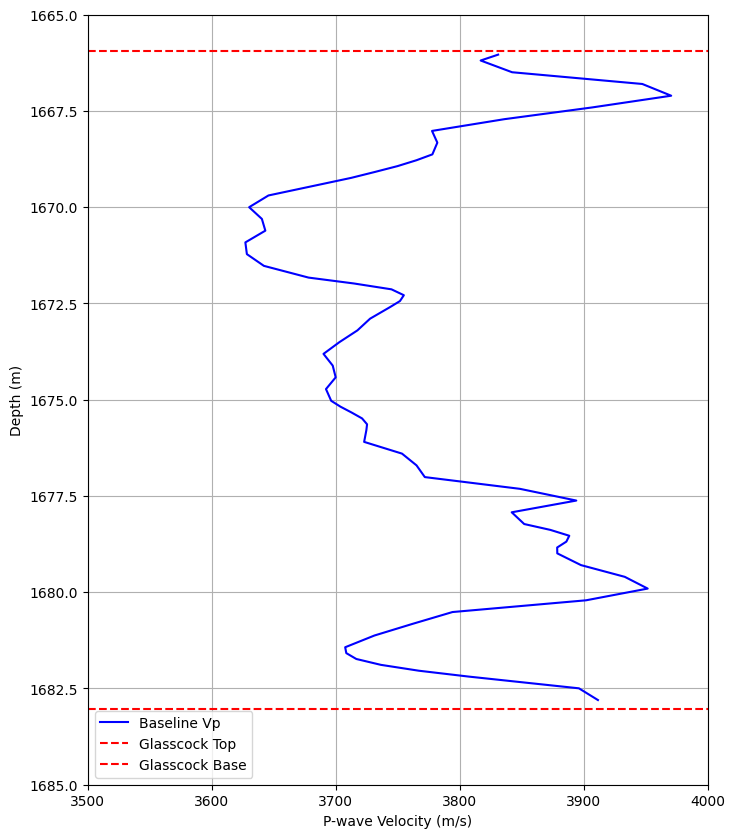

In [31]:
# Plot Vp comparison
plt.figure(figsize=(8, 10))
plt.plot(Vp_baseline, depth_injection, label='Baseline Vp', color='blue')
plt.axhline(y=formation_top, color='red', linestyle='--', label='Glasscock Top')
plt.axhline(y=formation_bottom, color='red', linestyle='--', label='Glasscock Base')
plt.xlabel('P-wave Velocity (m/s)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.ylim(1685, 1665)  # Example limits, adjust as needed
plt.xlim(3500, 4000)  # Example limits, adjust as needed